# Propogating geometric information: $k$-chains

*Background:*
In geometric GNNs, **geometric information**, such as the relative orientation of local neighbourhoods, is propagated via summing features from multiple layers in fixed dimensional spaces. 
The ideal architecture can be run for any number of layers to perfectly propagate geometric information without loss of information.
In practice, stacking geometric GNN layers may lead to distortion or **loss of information from distant nodes**.

*Experiment:*
To study the practical implications of depth in propagating geometric information beyond local neighbourhoods, we consider **$k$-chain geometric graphs** which generalise the examples from [Schütt et al., 2021](https://arxiv.org/abs/2102.03150). 
Each pair of $k$-chains consists of $k+2$ nodes with $k$ nodes arranged in a line and differentiated by the orientation of the $2$ end points.
Thus, $k$-chain graphs are $(\lfloor \frac{k}{2} \rfloor + 1)$-hop distinguishable, and $(\lfloor \frac{k}{2} \rfloor + 1)$ geometric GNN iterations should be theoretically sufficient to distinguish them.
In this notebook, we train equivariant and invariant geometric GNNs with an increasing number of layers to distinguish $k$-chains.

![k-chains](fig/kchains.png)

*Results:*
- Despite the supposed simplicity of the task, especially for small chain lengths, we find that popular equivariant GNNs such as E-GNN and TFN may require **more iterations** than theoretically sufficient.
- Notably, as the length of the chain gets larger than $k=4$, all equivariant GNNs tended to lose performance and required more than $(\lfloor \frac{k}{2} \rfloor + 1)$ iterations to solve the task.
- Invariant GNNs are **unable** to distinguish $k$-chains.

These results point to preliminary evidence of the **oversquashing** phenomenon when geometric information is propagated across multiple layers using fixed dimensional feature spaces.
These issues are most evident for E-GNN, which uses a single vector feature to aggregate and propagate geometric information.

In [28]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import torch
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_undirected
import e3nn
from functools import partial

print("PyTorch version {}".format(torch.__version__))
print("PyG version {}".format(torch_geometric.__version__))
print("e3nn version {}".format(e3nn.__version__))

from experiments.utils.plot_utils import plot_3d
from experiments.utils.train_utils import run_experiment
from models import SchNetModel, DimeNetPPModel, SphereNetModel, EGNNModel, GVPGNNModel, TFNModel, MACEModel

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
PyTorch version 2.4.1
PyG version 2.6.1
e3nn version 0.4.4
Using device: cuda


In [29]:
def create_kchains(k):
    assert k >= 2
    
    dataset = []

    # Graph 0
    atoms = torch.LongTensor( [0] + [0] + [0]*(k-1) + [0] )
    edge_index = torch.LongTensor( [ [i for i in range((k+2) - 1)], [i for i in range(1, k+2)] ] )
    pos = torch.FloatTensor(
        [[-4, -3, 0]] + 
        [[0, 5*i , 0] for i in range(k)] + 
        [[4, 5*(k-1) + 3, 0]]
    )
    center_of_mass = torch.mean(pos, dim=0)
    pos = pos - center_of_mass
    y = torch.LongTensor([0])  # Label 0
    data1 = Data(atoms=atoms, edge_index=edge_index, pos=pos, y=y)
    data1.edge_index = to_undirected(data1.edge_index)
    dataset.append(data1)
    
    # Graph 1
    atoms = torch.LongTensor( [0] + [0] + [0]*(k-1) + [0] )
    edge_index = torch.LongTensor( [ [i for i in range((k+2) - 1)], [i for i in range(1, k+2)] ] )
    pos = torch.FloatTensor(
        [[4, -3, 0]] + 
        [[0, 5*i , 0] for i in range(k)] + 
        [[4, 5*(k-1) + 3, 0]]
    )
    center_of_mass = torch.mean(pos, dim=0)
    pos = pos - center_of_mass
    y = torch.LongTensor([1])  # Label 1
    data2 = Data(atoms=atoms, edge_index=edge_index, pos=pos, y=y)
    data2.edge_index = to_undirected(data2.edge_index)
    dataset.append(data2)
    
    return dataset

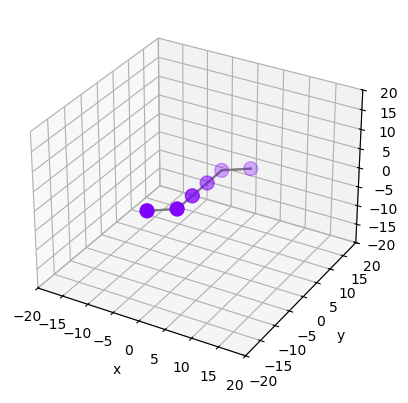

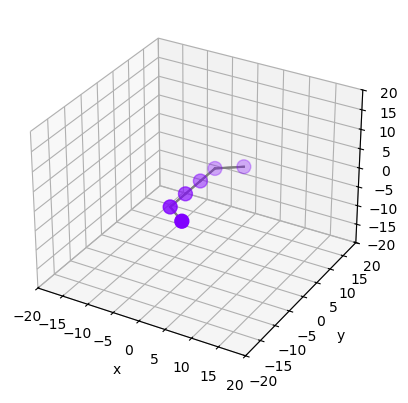

In [30]:
k = 4

# Create dataset
dataset = create_kchains(k=k)
for data in dataset:
    plot_3d(data, lim=5*k)

# Create dataloaders
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(dataset, batch_size=2, shuffle=False)

In [32]:
# Set model
model_name = "gvp"

for num_layers in range(k // 2 , k + 3):

    print(f"\nNumber of layers: {num_layers}")
    
    correlation = 2
    model = {
        "schnet": SchNetModel,
        "dimenet": DimeNetPPModel,
        "spherenet": SphereNetModel,
        "egnn": EGNNModel,
        "gvp": partial(GVPGNNModel, s_dim=32, v_dim=1),
        "tfn": TFNModel,
        "mace": partial(MACEModel, correlation=correlation),
    }[model_name](num_layers=num_layers, in_dim=1, out_dim=2)
    
    best_val_acc, test_acc, train_time = run_experiment(
        model, 
        dataloader,
        val_loader, 
        test_loader,
        n_epochs=100,
        n_times=10,
        device=device,
        verbose=False
    )


Number of layers: 2
Running experiment for GVPGNNModel (cuda).


100%|██████████| 10/10 [00:54<00:00,  5.41s/it]



Done! Averaged over 10 runs: 
 - Training time: 5.41s ± 0.07. 
 - Best validation accuracy: 50.000 ± 0.000. 
- Test accuracy: 50.0 ± 0.0. 


Number of layers: 3
Running experiment for GVPGNNModel (cuda).


100%|██████████| 10/10 [01:12<00:00,  7.29s/it]



Done! Averaged over 10 runs: 
 - Training time: 7.29s ± 0.10. 
 - Best validation accuracy: 60.000 ± 20.000. 
- Test accuracy: 60.0 ± 20.0. 


Number of layers: 4
Running experiment for GVPGNNModel (cuda).


100%|██████████| 10/10 [01:23<00:00,  8.32s/it]



Done! Averaged over 10 runs: 
 - Training time: 8.31s ± 0.36. 
 - Best validation accuracy: 95.000 ± 15.000. 
- Test accuracy: 95.0 ± 15.0. 


Number of layers: 5
Running experiment for GVPGNNModel (cuda).


100%|██████████| 10/10 [01:43<00:00, 10.39s/it]



Done! Averaged over 10 runs: 
 - Training time: 10.38s ± 0.60. 
 - Best validation accuracy: 90.000 ± 20.000. 
- Test accuracy: 90.0 ± 20.0. 


Number of layers: 6
Running experiment for GVPGNNModel (cuda).


100%|██████████| 10/10 [02:01<00:00, 12.10s/it]


Done! Averaged over 10 runs: 
 - Training time: 12.09s ± 0.70. 
 - Best validation accuracy: 95.000 ± 15.000. 
- Test accuracy: 95.0 ± 15.0. 



In [31]:
# ===================================================================
# 🧪 🧪 🧪 HMP Model Integration & Test 🧪 🧪 🧪
# ===================================================================
# This cell contains the new code to run the HMP-enhanced models.

# Import HMP Models
from models.hmp.schnet_hmp import HMP_SchNetModel

# --- Run HMP-ScHNet Experiment ---
print("\n" + "="*40)
print("Running HMP-ScHNet Experiment")
print("="*40)

for num_layers in range(k // 2, k + 3):
    print(f"\nNumber of layers: {num_layers}")
    
    # Instantiate HMP-ScHNet Model
    hmp_schnet_model = HMP_SchNetModel(
        num_layers=num_layers,
        in_dim=1,
        out_dim=2,
    ).to(device)

    run_experiment(
        hmp_schnet_model,
        dataloader,
        val_loader,
        test_loader,
        n_epochs=100,
        n_times=10,
        device=device,
        verbose=False,
        tau_annealing=True
    )


Running HMP-ScHNet Experiment

Number of layers: 2
Running experiment for HMP_SchNetModel (cuda).


  0%|          | 0/10 [00:00<?, ?it/s]


RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.cuda.FloatTensor instead (while checking arguments for embedding)

In [ ]:
# Import HMP Models
from models.hmp.dimenet_hmp import HMP_DimeNetModel
#from models.hmp.dimenet_hmp import HMP_DimeNetPPModel
# from models.hmp.spherenet_hmp import HMP_SphereNetModel
from models.hmp.egnn_hmp import HMP_EGNNModel
from models.hmp.gvpgnn_hmp import HMP_GVPGNNModel
from models.hmp.tfn_hmp import HMP_TFNModel
from models.hmp.mace_hmp import HMP_MACEModel

# --- Run HMP-DimeNet Experiment ---
print("\n" + "="*40)
print("Running HMP-DimeNet Experiment")
print("="*40)

for num_layers in range(k // 2, k + 3):
    print(f"\nNumber of layers: {num_layers}")
    
    # Instantiate HMP-DimeNet Model
    # hmp_dimenet_model = HMP_DimeNetModel(
    hmp_dimenet_model = HMP_DimeNetPPModel(
        num_layers=num_layers,
        in_dim=1,
        out_dim=2,
    ).to(device)

    run_experiment(
        hmp_dimenet_model,
        dataloader,
        val_loader,
        test_loader,
        n_epochs=100,
        n_times=10,
        device=device,
        verbose=False,
        tau_annealing=True
    )

# --- Run HMP-SphereNet Experiment ---
print("\n" + "="*40)
print("Running HMP-SphereNet Experiment")
print("="*40)

for num_layers in range(k // 2, k + 3):
    print(f"\nNumber of layers: {num_layers}")
    
    # Instantiate HMP-SphereNet Model
    hmp_spherenet_model = HMP_SphereNetModel(
        num_layers=num_layers,
        in_dim=1,
        out_dim=2,
    ).to(device)

    run_experiment(
        hmp_spherenet_model,
        dataloader,
        val_loader,
        test_loader,
        n_epochs=100,
        n_times=10,
        device=device,
        verbose=False,
        tau_annealing=True
    )

# --- Run HMP-EGNN Experiment ---
print("\n" + "="*40)
print("Running HMP-EGNN Experiment")
print("="*40)

for num_layers in range(k // 2, k + 3):
    print(f"\nNumber of layers: {num_layers}")
    
    # Instantiate HMP-EGNN Model
    # Using hyperparameters from paper (Section 4.3) where available
    hmp_egnn_model = HMP_EGNNModel(
        num_layers=num_layers,
        in_dim=1,
        out_dim=2,
        master_rate=0.25 # From paper
    ).to(device)

    run_experiment(
        hmp_egnn_model,
        dataloader,
        val_loader,
        test_loader,
        n_epochs=100,
        n_times=10,
        device=device,
        verbose=False,
        tau_annealing=True
    )

# --- Run HMP-GVPGNN Experiment ---
print("\n" + "="*40)
print("Running HMP-GVPGNN Experiment")
print("="*40)

for num_layers in range(k // 2, k + 3):
    print(f"\nNumber of layers: {num_layers}")
    
    # Instantiate HMP-GVPGNN Model
    hmp_gvpgnn_model = HMP_GVPGNNModel(
        num_layers=num_layers,
        in_dim=1,
        out_dim=2,
    ).to(device)

    run_experiment(
        hmp_gvpgnn_model,
        dataloader,
        val_loader,
        test_loader,
        n_epochs=100,
        n_times=10,
        device=device,
        verbose=False,
        tau_annealing=True
    )

# --- Run HMP-TFN Experiment ---
print("\n" + "="*40)
print("Running HMP-TFN Experiment")
print("="*40)

for num_layers in range(k // 2, k + 3):
    print(f"\nNumber of layers: {num_layers}")
    
    # Instantiate HMP-TFN Model
    hmp_tfn_model = HMP_TFNModel(
        num_layers=num_layers,
        in_dim=1,
        out_dim=2,
    ).to(device)

    run_experiment(
        hmp_tfn_model,
        dataloader,
        val_loader,
        test_loader,
        n_epochs=100,
        n_times=10,
        device=device,
        verbose=False,
        tau_annealing=True
    )

# --- Run HMP-MACE Experiment ---
print("\n" + "="*40)
print("Running HMP-MACE Experiment")
print("="*40)

for num_layers in range(k // 2, k + 3):
    print(f"\nNumber of layers: {num_layers}")
    
    correlation = 2 # Same as baseline MACE
    
    # Instantiate HMP-MACE Model
    # Using hyperparameters from paper (Section 4.3) where available
    hmp_mace_model = HMP_MACEModel(
        num_layers=num_layers,
        in_dim=1,
        out_dim=2,
        correlation=correlation,
        master_rate=0.25 # From paper
    ).to(device)
    
    run_experiment(
        hmp_mace_model,
        dataloader,
        val_loader,
        test_loader,
        n_epochs=100,
        n_times=10,
        device=device,
        verbose=False,
        tau_annealing=True
    )
